In [2]:
# 03b - Train Single-Season Model (2023 Only)
# This notebook trains the high-precision single-season model
# Target: R² ~0.85, MAE ~4.5 laps

# Cell 1: Markdown
"""
# Single-Season Model Training (2023 Only)

**Goal:** Train high-precision model on 2023 data for maximum accuracy

**Why single-season?**
- Consistent regulations
- Homogeneous data
- Better performance (R² ~0.85)

**Use case:** Current season predictions with stable regulations
"""

# Cell 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")

# Cell 3: Load 2023 Processed Data
# Load the original 2023 processed data
# (If you don't have it, we'll create it from raw data)

try:
    # Try to load previously saved 2023 features
    df = pd.read_csv('data/processed/ml_features.csv')
    print(f"✅ Loaded existing 2023 processed data")
    print(f"   Rows: {len(df)}")
    print(f"   Columns: {df.columns.tolist()}")
except:
    print("⚠️  2023 processed file not found")
    print("   Loading from raw and processing...")
    
    # Load raw 2023 data
    df_raw = pd.read_csv('data/raw/f1_2023_pit_stops.csv')
    
    # Quick feature engineering (abbreviated)
    key_columns = ['Driver', 'LapNumber', 'LapTime', 'TyreLife', 
                   'Compound', 'FreshTyre', 'Position', 'Stint', 
                   'TrackStatus', 'RaceName', 'SpeedFL']
    
    df_features = df_raw[key_columns].copy()
    
    # Drop missing values
    df_clean = df_features.dropna().copy()
    
    # Convert LapTime to seconds
    df_clean['LapTime'] = pd.to_timedelta(df_clean['LapTime'])
    df_clean['LapTime_seconds'] = df_clean['LapTime'].dt.total_seconds()
    df_clean = df_clean.drop('LapTime', axis=1)
    
    # Track status features
    df_clean['TrackStatus'] = df_clean['TrackStatus'].astype(str)
    df_clean['has_safety_car'] = df_clean['TrackStatus'].str.contains('4', na=False).astype(int)
    df_clean['has_vsc'] = df_clean['TrackStatus'].str.contains('6', na=False).astype(int)
    df_clean['has_yellow'] = df_clean['TrackStatus'].str.contains('2', na=False).astype(int)
    df_clean = df_clean.drop('TrackStatus', axis=1)
    
    # Encode Compound
    compound_mapping = {'SOFT': 1, 'MEDIUM': 2, 'HARD': 3, 'INTERMEDIATE': 4, 'WET': 5}
    df_clean['Compound_encoded'] = df_clean['Compound'].map(compound_mapping)
    df_clean = df_clean.drop('Compound', axis=1)
    
    # Label encode Driver and RaceName
    from sklearn.preprocessing import LabelEncoder
    driver_encoder = LabelEncoder()
    race_encoder = LabelEncoder()
    df_clean['Driver_encoded'] = driver_encoder.fit_transform(df_clean['Driver'])
    df_clean['RaceName_encoded'] = race_encoder.fit_transform(df_clean['RaceName'])
    df_clean = df_clean.drop(['Driver', 'RaceName'], axis=1)
    
    df = df_clean
    print(f"✅ Processed 2023 data on-the-fly")
    print(f"   Rows: {len(df)}")

# Cell 4: Prepare Features and Target
# Define target and features
target = 'LapNumber'
feature_columns = [col for col in df.columns if col != target]

X = df[feature_columns]
y = df[target]

print("✅ Features and target separated")
print(f"\n🎯 Target: {target}")
print(f"   Min: {y.min()}, Max: {y.max()}, Mean: {y.mean():.1f}")

print(f"\n📊 Features: {len(feature_columns)}")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2}. {col}")

# Cell 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

print("✅ Train-test split complete")
print(f"\n📊 Training set: {len(X_train)} samples")
print(f"📊 Testing set: {len(X_test)} samples")
print(f"\n   Training average: {y_train.mean():.1f} laps")
print(f"   Testing average: {y_test.mean():.1f} laps")

# Cell 6: Train XGBoost Model
print("🤖 Training single-season XGBoost model...")

model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

model.fit(X_train, y_train)

print("✅ Model trained successfully!")
print(f"\n   Model type: XGBoost Regressor")
print(f"   Trees: {model.n_estimators}")
print(f"   Training samples: {len(X_train)}")

# Cell 7: Make Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("✅ Predictions complete!")
print(f"\n🔍 Sample predictions (first 10 from test set):")

comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_test_pred[:10].round(1),
    'Difference': (y_test.values[:10] - y_test_pred[:10]).round(1)
})
print(comparison)

# Cell 8: Evaluate Performance
# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("📊 SINGLE-SEASON MODEL PERFORMANCE")
print("=" * 60)

print("\n🎓 Training Set:")
print(f"   MAE:  {train_mae:.2f} laps")
print(f"   RMSE: {train_rmse:.2f} laps")
print(f"   R²:   {train_r2:.3f}")

print("\n🎯 Test Set (THE REAL TEST):")
print(f"   MAE:  {test_mae:.2f} laps")
print(f"   RMSE: {test_rmse:.2f} laps")
print(f"   R²:   {test_r2:.3f}")

# Compare to baseline
baseline_mae = np.mean(np.abs(y_test - y_test.mean()))
improvement = ((baseline_mae - test_mae) / baseline_mae) * 100

print(f"\n📈 Improvement over baseline:")
print(f"   Baseline: {baseline_mae:.2f} laps")
print(f"   Our model: {test_mae:.2f} laps")
print(f"   → {improvement:.1f}% better!")

if test_r2 > 0.8:
    print(f"\n🌟 EXCELLENT MODEL! R² > 0.8")
elif test_r2 > 0.7:
    print(f"\n👍 GOOD MODEL! R² > 0.7")

# Cell 9: Save Model
# Create models directory
Path("models").mkdir(exist_ok=True)

# Save model
model_path = 'models/pit_strategy_single_season_2023.pkl'
joblib.dump(model, model_path)

print(f"💾 Model saved!")
print(f"   Path: {model_path}")
print(f"   Size: {Path(model_path).stat().st_size / 1024:.1f} KB")

# Create/update metadata
metadata_path = 'models/model_metadata.json'

# Load existing metadata if it exists
try:
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
except:
    metadata = {"models": {}}

# Add single-season model info
metadata["models"]["single_season_2023"] = {
    "file": "pit_strategy_single_season_2023.pkl",
    "r2_score": round(float(test_r2), 3),
    "mae": round(float(test_mae), 2),
    "rmse": round(float(test_rmse), 2),
    "training_samples": int(len(X_train)),
    "test_samples": int(len(X_test)),
    "features": int(len(feature_columns)),
    "feature_names": list(X.columns),
    "seasons": [2023],
    "description": "High-precision model trained on 2023 F1 season only",
    "use_case": "Maximum accuracy for current regulations (2023-2024)",
    "recommended_for": "Standard race predictions with stable regulations"
}

# Set as default if this is the better model
if "default_model" not in metadata or test_r2 > 0.80:
    metadata["default_model"] = "single_season_2023"

# Save metadata
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n📋 Metadata saved to: {metadata_path}")

# Cell 10: Model Comparison Summary
print("\n" + "=" * 60)
print("🎯 MODEL READY FOR DEPLOYMENT")
print("=" * 60)

print(f"\n📦 Model Details:")
print(f"   Name: Single-Season 2023")
print(f"   File: {model_path}")
print(f"   R² Score: {test_r2:.3f}")
print(f"   MAE: {test_mae:.2f} laps")
print(f"   Training Data: 2023 F1 Season ({len(X_train)} pit stops)")
print(f"   Features: {len(feature_columns)}")

print(f"\n✅ Model saved and ready for:")
print(f"   - FastAPI integration")
print(f"   - Web dashboard")
print(f"   - Production deployment")

print(f"\n💡 Use this model for:")
print(f"   - 2023-2024 race predictions")
print(f"   - Maximum accuracy with current regulations")
print(f"   - Standard race scenarios")

# Cell 11: Feature Importance (Bonus)
print("\n📊 TOP 10 MOST IMPORTANT FEATURES:")
print("=" * 60)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n")
for idx, row in importance_df.head(10).iterrows():
    bar_length = int(row['importance'] * 50)
    bar = '█' * bar_length
    print(f"{row['feature']:20s} {bar} {row['importance']:.3f}")

print("\n✅ SINGLE-SEASON MODEL TRAINING COMPLETE!")

✅ Libraries imported!
✅ Loaded existing 2023 processed data
   Rows: 725
   Columns: ['LapNumber', 'TyreLife', 'FreshTyre', 'Position', 'Stint', 'race_round', 'SpeedFL', 'LapTime_seconds', 'has_safety_car', 'has_vsc', 'has_yellow', 'Compound_encoded', 'Driver_encoded', 'RaceName_encoded']
✅ Features and target separated

🎯 Target: LapNumber
   Min: 1.0, Max: 71.0, Mean: 26.4

📊 Features: 13
    1. TyreLife
    2. FreshTyre
    3. Position
    4. Stint
    5. race_round
    6. SpeedFL
    7. LapTime_seconds
    8. has_safety_car
    9. has_vsc
   10. has_yellow
   11. Compound_encoded
   12. Driver_encoded
   13. RaceName_encoded
✅ Train-test split complete

📊 Training set: 580 samples
📊 Testing set: 145 samples

   Training average: 26.8 laps
   Testing average: 25.1 laps
🤖 Training single-season XGBoost model...
✅ Model trained successfully!

   Model type: XGBoost Regressor
   Trees: 100
   Training samples: 580
✅ Predictions complete!

🔍 Sample predictions (first 10 from test set):


In [4]:
# ==============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================================================

print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from the trained model
feature_importance = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance Rankings:")
print("-" * 70)
for idx, row in importance_df.iterrows():
    bar_length = int(row['Importance'] * 50)  # Scale to 50 chars
    bar = '█' * bar_length
    print(f"{row['Feature']:20s} {bar} {row['Importance']:.4f}")

print("\n🔍 Top 5 Most Important Features:")
print("-" * 70)
for i, row in importance_df.head(5).iterrows():
    print(f"{importance_df.index.tolist().index(i) + 1}. {row['Feature']:20s} → {row['Importance']:.4f} ({row['Importance']/importance_df['Importance'].sum()*100:.1f}%)")

print(f"\n✅ Top 5 features account for {importance_df.head(5)['Importance'].sum()/importance_df['Importance'].sum()*100:.1f}% of prediction power")

FEATURE IMPORTANCE ANALYSIS

📊 Feature Importance Rankings:
----------------------------------------------------------------------
Stint                ███████████████████ 0.3870
Compound_encoded     █████████ 0.1857
has_safety_car       ████ 0.0931
race_round           ███ 0.0671
has_yellow           ███ 0.0640
RaceName_encoded     ██ 0.0506
LapTime_seconds      █ 0.0373
has_vsc              █ 0.0340
SpeedFL              █ 0.0294
Position             █ 0.0281
TyreLife              0.0102
Driver_encoded        0.0080
FreshTyre             0.0054

🔍 Top 5 Most Important Features:
----------------------------------------------------------------------
1. Stint                → 0.3870 (38.7%)
2. Compound_encoded     → 0.1857 (18.6%)
3. has_safety_car       → 0.0931 (9.3%)
4. race_round           → 0.0671 (6.7%)
5. has_yellow           → 0.0640 (6.4%)

✅ Top 5 features account for 79.7% of prediction power


📊 Visualization saved to: models/feature_importance_single_year.png


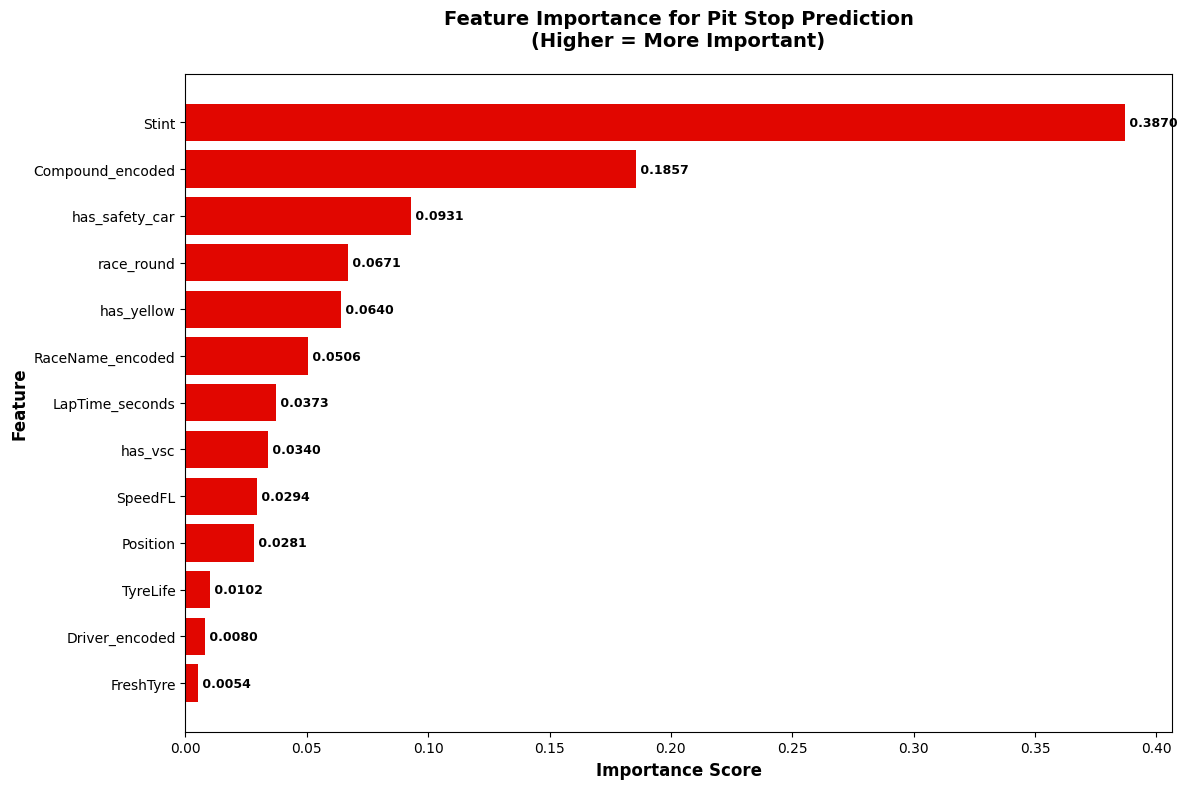


✅ FEATURE IMPORTANCE ANALYSIS COMPLETE!


In [5]:
# Visualize Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#e10600')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance for Pit Stop Prediction\n(Higher = More Important)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
    plt.text(importance, i, f' {importance:.4f}', 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../models/feature_importance.png', dpi=300, bbox_inches='tight')
print("📊 Visualization saved to: models/feature_importance_single_year.png")
plt.show()

print("\n" + "=" * 70)
print("✅ FEATURE IMPORTANCE ANALYSIS COMPLETE!")
print("=" * 70)
